In [1]:
import psycopg2
import pandas as pd
from getpass import getpass
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss, roc_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(13)
pd.options.display.max_columns = 999

In [2]:
user = getpass()
password = getpass()
ip = getpass()
port = getpass()
dbname = getpass()

········
········
········
········
········


In [3]:
db_connection_string = 'postgresql://{}:{}@{}:{}/{}'

with psycopg2.connect(db_connection_string.format(user,
                                                  password,
                                                  ip,
                                                  port,
                                                  dbname)) as con:

    sql = """SELECT game_evals.game_link,
                    chess_games.player_elo,
                    half_move,
                    result,
                    evaluation
             from game_evals
             JOIN chess_games on chess_games.game_link = game_evals.game_link
             WHERE evaluation not in (-9999, 9999)
             --and chess_games.player_elo > 2200
             and chess_games.time_control_category = 'blitz'
             and random() < 0.045  --tablesample can't be used with non-materialized views
             ;
             """
    df = pd.read_sql_query(sql, con)

In [4]:
df.head()

,game_link,player_elo,half_move,result,evaluation
0,https://lichess.org/lmXA6BBT,1854.0,17,0-1,0.47
1,https://lichess.org/AHk0wewu,1829.0,23,1-0,0.98
2,https://lichess.org/BL4ICcDf,1825.0,34,1-0,0.00
3,https://lichess.org/k85jGrpQ,1817.0,13,0-1,0.66
4,https://lichess.org/6xQ0FSg1,1784.0,110,1/2-1/2,-4.08


In [5]:
df.shape

(40534, 5)

In [6]:
df['result_points'] = (df['result'] == '1-0') + (df['result'] == '1/2-1/2') * 0.5
df['evaluation_binned'] = (df['evaluation'] / 3).round(decimals=0) * 3

In [7]:
df.head(100)

,game_link,player_elo,half_move,result,evaluation,result_points,evaluation_binned
0,https://lichess.org/lmXA6BBT,1854.0,17,0-1,0.47,0.0,0.0
1,https://lichess.org/AHk0wewu,1829.0,23,1-0,0.98,1.0,0.0
2,https://lichess.org/BL4ICcDf,1825.0,34,1-0,0.00,1.0,0.0
3,https://lichess.org/k85jGrpQ,1817.0,13,0-1,0.66,0.0,0.0
4,https://lichess.org/6xQ0FSg1,1784.0,110,1/2-1/2,-4.08,0.5,-3.0
...,...,...,...,...,...,...,...
95,https://lichess.org/dZZez3sC,1791.0,12,1-0,-0.25,1.0,-0.0
96,https://lichess.org/poqgznAq,1779.0,20,1-0,-0.73,1.0,-0.0
97,https://lichess.org/Re198e1D,1771.0,60,0-1,0.29,0.0,0.0
98,https://lichess.org/z1ahLzJ7,1743.0,82,0-1,-8.60,0.0,-9.0


In [8]:
df['evaluation_binned'].max(), df['evaluation_binned'].min()

(90.0, -87.0)

In [9]:
grouped = df.groupby(['evaluation_binned'], as_index=False).agg({'result_points': 'mean'})

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df['evaluation'], df['result_points'], test_size=0.2, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=13)

x_train.shape, x_val.shape, x_test.shape

((24320,), (8107,), (8107,))

/home/gpt/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Pre-outlier removal size: (24320,)
Post-outlier removal size: (19469,)


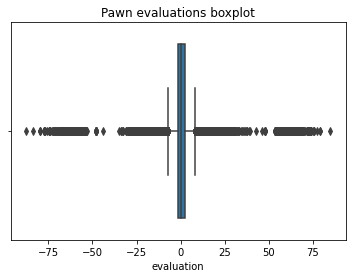

In [11]:
sns.boxplot(x_train)
plt.title('Pawn evaluations boxplot')

p25 = np.percentile(x_train, 25)
p75 = np.percentile(x_train, 75)
iqr = p75 - p25

print(f'Pre-outlier removal size: {x_train.shape}')
y_train = y_train[x_train > p25 - 1.5 * iqr]
y_train = y_train[x_train < p75 + 1.5 * iqr]
x_train = x_train[x_train > p25 - 1.5 * iqr]
x_train = x_train[x_train < p75 + 1.5 * iqr]
print(f'Post-outlier removal size: {x_train.shape}')

/home/gpt/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


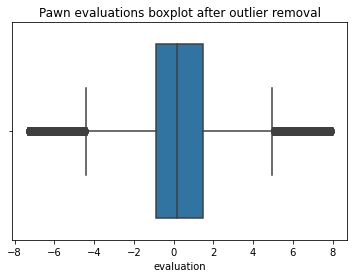

In [12]:
plt.title('Pawn evaluations boxplot after outlier removal')
sns.boxplot(x_train);

In [13]:
def logifunc(x, x0, k, A, B, offset):
    return A / (B + np.exp(-k * (x - x0))) + offset

x0: 10.63, k: 0.28, A: 11.47, B: 21.60, offset: 0.23


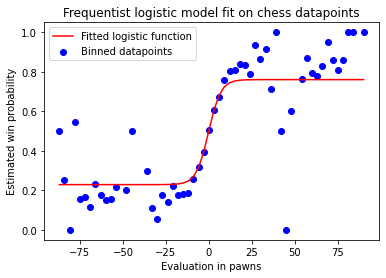

In [14]:
# reference: https://chesscomputer.tumblr.com/post/98632536555/using-the-stockfish-position-evaluation-score-to
popt, pcov = curve_fit(logifunc, x_train, y_train, p0=[0, 0.5, 1, 1, 0], maxfev=10000)

plt.scatter(grouped['evaluation_binned'],
            grouped['result_points'],
            color='b',
            label='Binned datapoints')
plt.plot(grouped['evaluation_binned'],
         logifunc(grouped['evaluation_binned'], *popt),
         'r-',
         label='Fitted logistic function')
plt.xlabel('Evaluation in pawns')
plt.ylabel('Estimated win probability')
plt.title('Frequentist logistic model fit on chess datapoints')
plt.legend()

print('x0: {:.2f}, k: {:.2f}, A: {:.2f}, B: {:.2f}, offset: {:.2f}'.format(*popt))

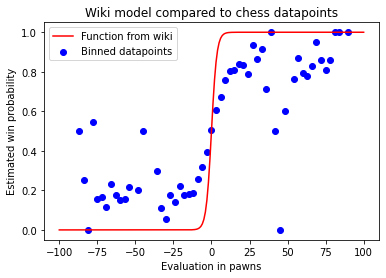

In [15]:
plt.scatter(grouped['evaluation_binned'], grouped['result_points'], color='b', label='Binned datapoints')
# reference: https://www.chessprogramming.org/Pawn_Advantage,_Win_Percentage,_and_Elo
plt.plot(range(-100, 101),
         [1 / (1 + 10 ** (-p / 4)) for p in range(-100, 101)],
         color='r',
         label='Function from wiki')
plt.xlabel('Evaluation in pawns')
plt.ylabel('Estimated win probability')
plt.title('Wiki model compared to chess datapoints')
plt.legend(loc='best');

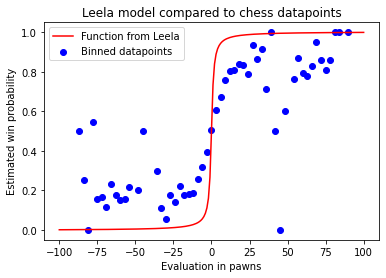

In [16]:
plt.scatter(grouped['evaluation_binned'], grouped['result_points'], color='b', label='Binned datapoints')
# reference: Leela Chess Zero
plt.plot(range(-100, 101),
         [((np.arctan(p / (0.01 * 111.714640912)) / 1.5620688421) + 1) / 2
          for p in range(-100, 101)],
         color='r',
         label='Function from Leela')
plt.xlabel('Evaluation in pawns')
plt.ylabel('Estimated win probability')
plt.title('Leela model compared to chess datapoints')
plt.legend(loc='best');

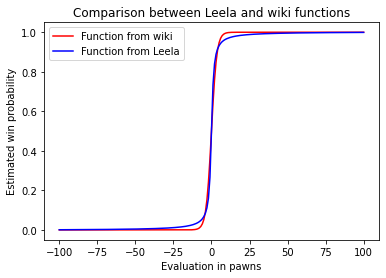

In [17]:
plt.plot(range(-100, 101),
         [1 / (1 + 10 ** (-p / 4)) for p in range(-100, 101)],
         color='r',
         label='Function from wiki')
plt.plot(range(-100, 101),
         [((np.arctan(p / (0.01 * 111.714640912)) / 1.5620688421) + 1) / 2
          for p in range(-100, 101)],
         color='b',
         label='Function from Leela')
plt.xlabel('Evaluation in pawns')
plt.ylabel('Estimated win probability')
plt.title('Comparison between Leela and wiki functions')
plt.legend(loc='best');

In [18]:
def leelafunc(p):
    return ((np.arctan(p / (0.01 * 111.714640912)) / 1.5620688421) + 1) / 2

In [19]:
lr = LogisticRegressionCV(Cs=[10 ** (x / 10) for x in range(-80, 80, 5)],
                          l1_ratios=[x / 10 for x in range(11)],
                          n_jobs=-1,
                          random_state=13,
                          penalty='elasticnet',
                          solver='saga',
                          )
lr.fit(x_train.values.reshape(-1, 1), y_train.astype(str))
y_pred_lr = pd.Series(lr.predict_proba(x_val.values.reshape(-1, 1)) @ np.array([0, 0.5, 1]))

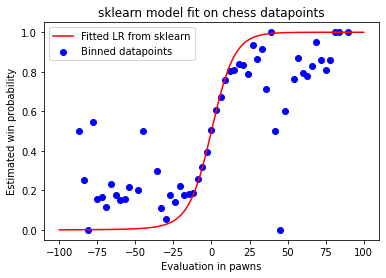

In [20]:
plt.scatter(grouped['evaluation_binned'], grouped['result_points'], color='b', label='Binned datapoints')
plt.plot(range(-100, 101),
         [lr.predict_proba(np.array(p).reshape(-1, 1)) @ np.array([0, 0.5, 1])
          for p in range(-100, 101)],
         color='r',
         label='Fitted LR from sklearn')
plt.xlabel('Evaluation in pawns')
plt.ylabel('Estimated win probability')
plt.title('sklearn model fit on chess datapoints')
plt.legend(loc='best');

In [21]:
y_pred_leela = leelafunc(x_val)

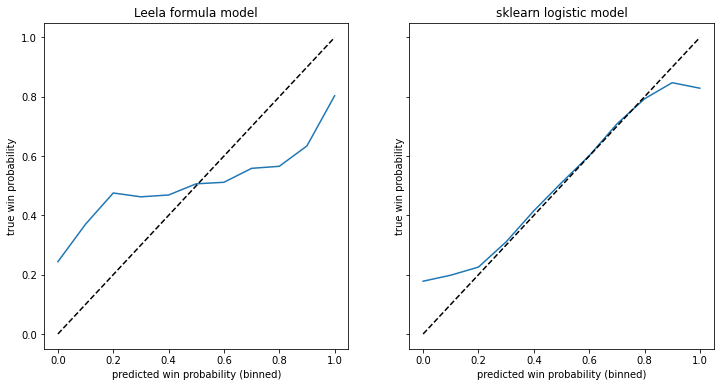

In [22]:
# calibration plots

predictions = pd.concat([y_val.reset_index(drop=True),
                         y_pred_leela.reset_index(drop=True),
                         y_pred_lr.reset_index(drop=True),
                         ],
                        axis=1)

predictions.columns = ['true', 'pred_leela', 'pred_lr']
predictions['binned_leela'] = predictions['pred_leela'].round(decimals=1)
predictions['binned_lr'] = predictions['pred_lr'].round(decimals=1)

calibration_leela = predictions.groupby(['binned_leela'], as_index=False).agg({'true': 'mean'})
calibration_lr = predictions.groupby(['binned_lr'], as_index=False).agg({'true': 'mean'})

fig, axs = plt.subplots(figsize=(12, 6), ncols=2, sharey=True)

axs[0].plot(calibration_leela['binned_leela'], calibration_leela['true'])
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlabel('predicted win probability (binned)')
axs[0].set_ylabel('true win probability')
axs[0].set_title('Leela formula model')

axs[1].plot(calibration_lr['binned_lr'], calibration_lr['true'])
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_xlabel('predicted win probability (binned)')
axs[1].set_ylabel('true win probability')
axs[1].set_title('sklearn logistic model');

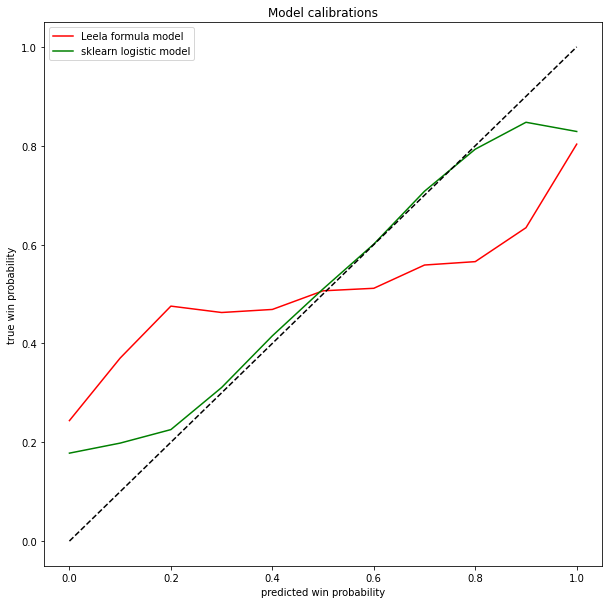

In [23]:
plt.figure(figsize=(10, 10))

plt.plot(calibration_leela['binned_leela'], calibration_leela['true'], color='r', label='Leela formula model')
plt.plot(calibration_lr['binned_lr'], calibration_lr['true'], color='g', label='sklearn logistic model')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('predicted win probability')
plt.ylabel('true win probability')
plt.title('Model calibrations')
plt.legend(loc='best');

In [24]:
for name, pred in {'leela': y_pred_leela, 'LR': y_pred_lr}.items():
    print(name)
    brier = brier_score_loss(y_val == 1, pred.clip(0, 1))
    auc = roc_auc_score(y_val == 1, pred.clip(0, 1))
    log = log_loss(y_val == 1, pred.clip(0, 1))
    print(f'Brier score: {brier:.4f},\nAUC: {auc:.4f},\nLog loss: {log:.4f}\n')

leela
Brier score: 0.2660,
AUC: 0.6733,
Log loss: 0.8142

LR
Brier score: 0.2270,
AUC: 0.6733,
Log loss: 0.6633



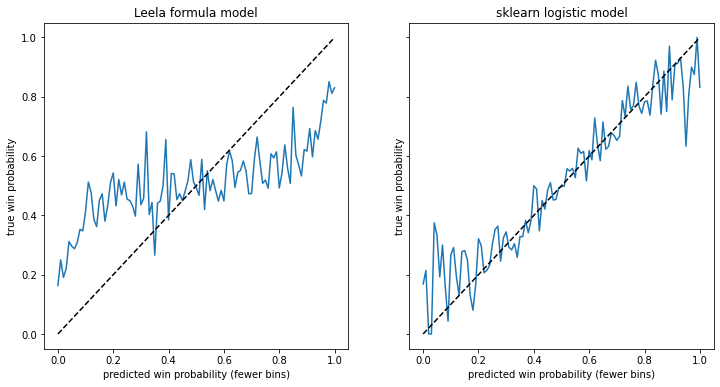

In [25]:
predictions['binned_leela'] = predictions['pred_leela'].round(decimals=2)
predictions['binned_lr'] = predictions['pred_lr'].round(decimals=2)
calibration_leela = predictions.groupby(['binned_leela'], as_index=False).agg({'true': 'mean'})
calibration_lr = predictions.groupby(['binned_lr'], as_index=False).agg({'true': 'mean'})

fig, axs = plt.subplots(figsize=(12, 6), ncols=2, sharey=True)

axs[0].plot(calibration_leela['binned_leela'], calibration_leela['true'])
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlabel('predicted win probability (fewer bins)')
axs[0].set_ylabel('true win probability')
axs[0].set_title('Leela formula model')

axs[1].plot(calibration_lr['binned_lr'], calibration_lr['true'])
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_xlabel('predicted win probability (fewer bins)')
axs[1].set_ylabel('true win probability')
axs[1].set_title('sklearn logistic model');

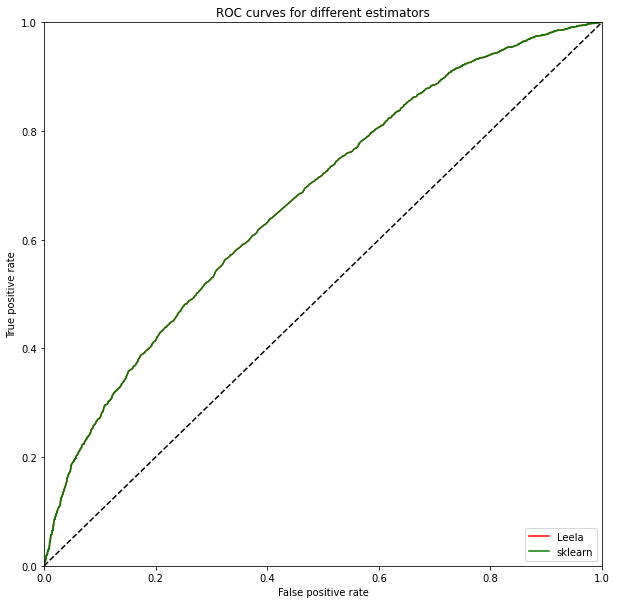

In [26]:
plt.figure(figsize=(10, 10))

fpr, tpr, _ = roc_curve(y_val == 1, y_pred_leela)
plt.plot(fpr, tpr, color='r', label='Leela')

fpr, tpr, _ = roc_curve(y_val == 1, y_pred_lr)
plt.plot(fpr, tpr, color='g', label='sklearn')

plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC curves for different estimators')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='lower right');

In [27]:
predictions.head()

,true,pred_leela,pred_lr,binned_leela,binned_lr
0,0.0,0.032502,0.214629,0.03,0.21
1,1.0,0.843737,0.568791,0.84,0.57
2,1.0,0.293631,0.473896,0.29,0.47
3,0.0,0.029057,0.192265,0.03,0.19
4,1.0,0.076277,0.360590,0.08,0.36


In [28]:
# disagreeing by more than 0.1 probability
predictions[(predictions['pred_lr'] - predictions['pred_leela']).abs() > 0.1]

,true,pred_leela,pred_lr,binned_leela,binned_lr
0,0.0,0.032502,0.214629,0.03,0.21
1,1.0,0.843737,0.568791,0.84,0.57
2,1.0,0.293631,0.473896,0.29,0.47
3,0.0,0.029057,0.192265,0.03,0.19
4,1.0,0.076277,0.360590,0.08,0.36
...,...,...,...,...,...
8099,0.0,0.185043,0.446571,0.19,0.45
8101,1.0,0.963652,0.769794,0.96,0.77
8102,1.0,0.739954,0.535569,0.74,0.54
8105,0.0,0.952977,0.720335,0.95,0.72


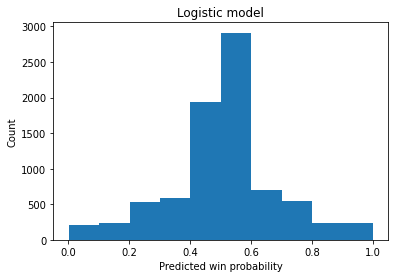

In [29]:
plt.hist(predictions['pred_lr'])
plt.title('Logistic model')
plt.xlabel('Predicted win probability')
plt.ylabel('Count');

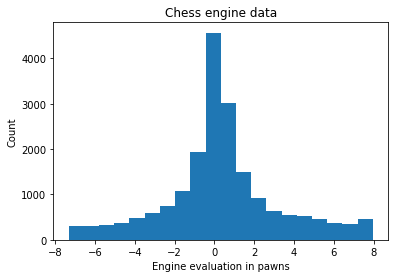

In [30]:
plt.hist(x_train, bins=20)
plt.title('Chess engine data')
plt.xlabel('Engine evaluation in pawns')
plt.ylabel('Count');

In [31]:
# how does the logistic model perform out of sample?
y_pred = pd.Series(lr.predict_proba(x_test.values.reshape(-1, 1)) @ np.array([0, 0.5, 1]))

In [32]:
brier = brier_score_loss(y_test == 1, y_pred)
auc = roc_auc_score(y_test == 1, y_pred)
log = log_loss(y_test == 1, y_pred)
print(f'Brier score: {brier:.4f},\nAUC: {auc:.4f},\nLog loss: {log:.4f}')

Brier score: 0.2278,
AUC: 0.6765,
Log loss: 0.6691


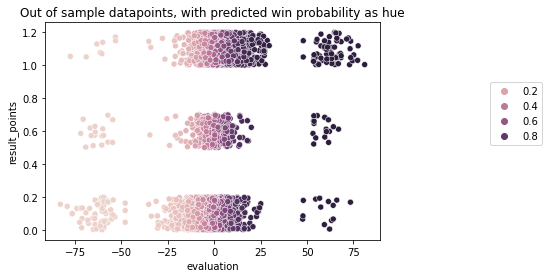

In [33]:
test_results = pd.concat([x_test.reset_index(drop=True),
                          y_test.reset_index(drop=True),
                          y_pred.reset_index(drop=True)],
                         axis=1)
test_results.columns = ['evaluation', 'result_points', 'predicted_points']

test_results['binned_predictions'] = test_results['predicted_points'].round(decimals=1)
test_calibration = test_results.groupby(['binned_predictions'], as_index=False).agg({'result_points': 'mean'})

# add jitter for visibility
test_results['result_points'] += np.random.random(size=test_results['result_points'].shape) / 5

sns.scatterplot(x='evaluation', y='result_points', hue='predicted_points', data=test_results)
plt.legend(bbox_to_anchor=[1.5, 0.75])
plt.title('Out of sample datapoints, with predicted win probability as hue');

In [34]:
test_results

,evaluation,result_points,predicted_points,binned_predictions
0,0.00,1.155540,0.501434,0.5
1,-6.04,0.047508,0.314126,0.3
2,-3.65,1.164856,0.384257,0.4
3,-4.26,0.193150,0.365689,0.4
4,-0.77,0.194520,0.476185,0.5
...,...,...,...,...
8102,-13.75,1.098832,0.147733,0.1
8103,0.92,1.033077,0.531637,0.5
8104,1.31,0.101976,0.544400,0.5
8105,1.89,1.119260,0.563285,0.6


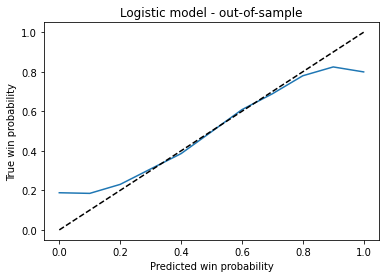

In [35]:
plt.plot(test_calibration['binned_predictions'], test_calibration['result_points'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted win probability')
plt.ylabel('True win probability')
plt.title('Logistic model - out-of-sample');

In [36]:
test_calibration

,binned_predictions,result_points
0,0.0,0.188034
1,0.1,0.184848
2,0.2,0.230303
3,0.3,0.308333
4,0.4,0.385850
5,0.5,0.496568
6,0.6,0.608422
7,0.7,0.688563
8,0.8,0.779841
9,0.9,0.824519


In [37]:
joblib.dump(lr, 'lr_wp_model.joblib')

['lr_wp_model.joblib']